In [1]:
# Install pylibCZIrw and dependencies
! pip install --upgrade pip
! pip install "pylibCZIrw~=4.1" "cztile>=0.0,<1.0" matplotlib tqdm pooch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 17.4 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 53.1 MB/s eta 0:00:00


In [2]:
from pylibCZIrw import czi as pyczi
from pylibCZIrw.czi import ReaderFileInputTypes, CacheOptions, CacheType
import json
import timeit
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import numpy as np
import os, sys
from tqdm import tqdm
from tqdm.contrib import itertools as it
from matplotlib.patches import Rectangle
from IPython.display import display, JSON

from skimage.filters import threshold_otsu
from skimage.measure import label, regionprops

# show the used python env
print("Using:", sys.executable)

Using: /usr/bin/python3


## One file example

In [9]:
selected_images = ['sample5_10','sample5_11', 'sample5_12', 'sample5_13', 'sample5_15', 'sample5_16', 'sample5_17', 'sample5_18', 'sample5_19', 'sample5_20']

{0: 'Gray16'}
Array Shape:  (1038, 1388, 1)


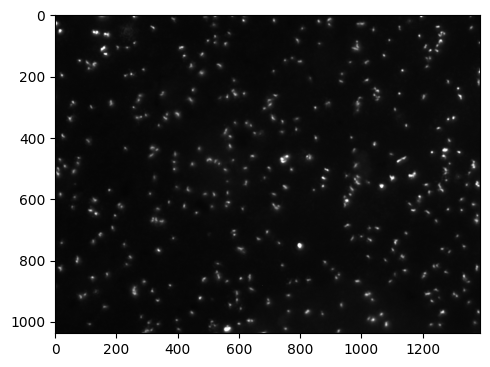

In [75]:
filepath = '/content/drive/MyDrive/Cheng_project3_SAR11_Proteomics/Culture_records/2024_11_06_HTCC1062_Nitrogen_and_Revival/SAR11_Microscopic_Images/sample1_1.czi'
# open the CZI for reading using a context manager (preferred way to do it)
with pyczi.open_czi(filepath) as czidoc:
  # get the raw metadata as a dictionary
  md_dict = czidoc.metadata

  # get all pixel types as a dictionary, where the key is the channel index
  pixel_type = czidoc.pixel_types
  frame = czidoc.read()

metadata_scale = 1e6*float(md_dict['ImageDocument']['Metadata']['Scaling']['Items']['Distance'][0]['Value'])

print(pixel_type)
print("Array Shape: ", frame.shape)

fig, ax = plt.subplots(figsize=(5, 5))

image = frame[...,0]
ax.imshow(image, cmap=cm.gray)
#ax.set_title("Image")

fig.tight_layout()
fig.show()

{0: 'Gray16'}
Array Shape:  (1038, 1388, 1)


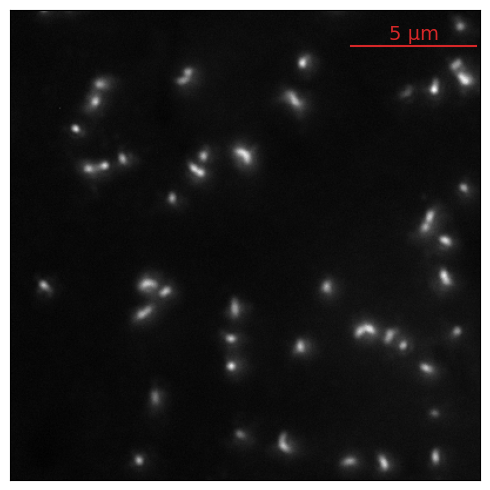

In [80]:
filepath = '/content/drive/MyDrive/Cheng_project3_SAR11_Proteomics/Culture_records/2024_11_06_HTCC1062_Nitrogen_and_Revival/SAR11_Microscopic_Images/sample1_1.czi'
# open the CZI for reading using a context manager (preferred way to do it)
with pyczi.open_czi(filepath) as czidoc:
  # get the raw metadata as a dictionary
  md_dict = czidoc.metadata

  # get all pixel types as a dictionary, where the key is the channel index
  pixel_type = czidoc.pixel_types
  frame = czidoc.read()

print(pixel_type)
print("Array Shape: ", frame.shape)

fig, ax = plt.subplots(figsize=(5, 5))

image = frame[...,0]
ax.imshow(image[200:600,200:600], cmap=cm.gray)

ax.plot([290,290+5/metadata_scale], [30,30], 'C3')
ax.text(290+1.5/metadata_scale, 25, '5 μm', color='C3', fontsize=14)
ax.set_xticks([])
ax.set_yticks([])
#ax.set_title("Image")

fig.tight_layout()

fig.savefig('/content/sample_1.pdf')
fig.show()

530


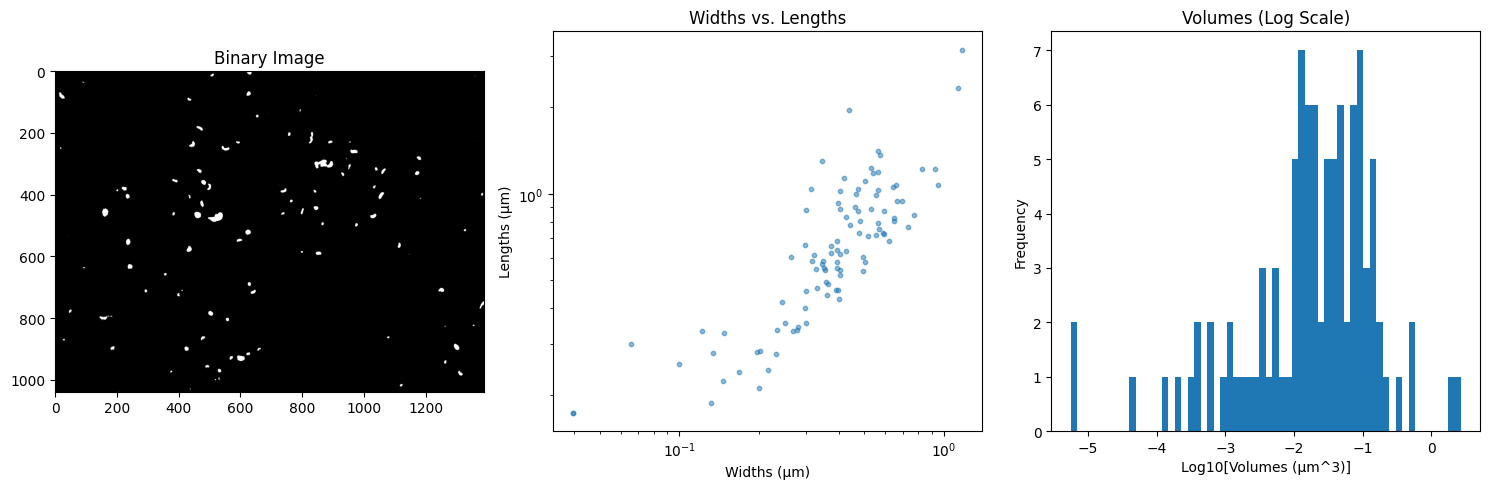

In [ ]:
# prompt: binarize variable "image" using otsu method. For the binarized image, calculate the length and width of each connected region.
# Binarize the image using Otsu's method
thresh = threshold_otsu(image)
print(thresh)
binary_image = image > thresh

# Label connected regions
labeled_image = label(binary_image)

# Calculate properties of each region
regions = regionprops(labeled_image)

lengths = []
widths = []
for region in regions:
  length = region.major_axis_length
  width = region.minor_axis_length
  lengths.append(length)
  widths.append(width)

metadata_scale = 1e6*float(md_dict['ImageDocument']['Metadata']['Scaling']['Items']['Distance'][0]['Value'])

lengths = np.array(lengths)*metadata_scale
widths = np.array(widths)*metadata_scale
volumes = 4/3*np.pi*(widths/2)**3*lengths

lengths = lengths[volumes > 0]
widths = widths[volumes > 0]
volumes = volumes[volumes > 0]

# prompt: display 1. 'binary_image'; 2. the density scatter plot of 'widths' vs. 'lengths'; 3. histogram of 'volumes' (in log scale) in subplots

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Display the binary image
axes[0].imshow(binary_image, cmap='gray')
axes[0].set_title('Binary Image')

# Density scatter plot of widths vs. lengths
axes[1].scatter(widths, lengths, s=10, alpha=0.5)  # Adjust s and alpha as needed
axes[1].set_xlabel('Widths (μm)')
axes[1].set_ylabel('Lengths (μm)')
axes[1].set_title('Widths vs. Lengths')
axes[1].set_xscale('log')
axes[1].set_yscale('log')

# Histogram of volumes (log scale)
axes[2].hist(np.log10(volumes), bins=60)
axes[2].set_xlabel('Log10[Volumes (μm^3)]')
axes[2].set_ylabel('Frequency')
axes[2].set_title('Volumes (Log Scale)')

plt.tight_layout()
plt.show()

## 2. Batch analyses for "sample 1"

In [ ]:
# prompt: list all the files with "sample1" under the directory '/content/drive/MyDrive/Cheng_project3_SAR11_Proteomics/Culture_records/2024_11_06_HTCC1062_Nitrogen_and_Revival/SAR11_Microscopic_Images/'

import os

def list_files_with_pattern(directory, pattern):
  """Lists files in a directory that match a given pattern.

  Args:
    directory: The directory to search in.
    pattern: The pattern to match filenames against.

  Returns:
    A list of filenames that match the pattern.
  """
  matching_files = []
  for filename in os.listdir(directory):
    if pattern in filename:
      matching_files.append(filename)
  return matching_files


directory_to_search = '/content/drive/MyDrive/Cheng_project3_SAR11_Proteomics/Culture_records/2024_11_06_HTCC1062_Nitrogen_and_Revival/SAR11_Microscopic_Images/'
pattern_to_match = 'sample1'

def analyze_sample(pattern_to_match):
  matching_files = list_files_with_pattern(directory_to_search, pattern_to_match)
  #matching_files_names = []
  if matching_files:
    print(f"Files in '{directory_to_search}' containing '{pattern_to_match}':")
    #all_lengths = np.array([])
    #all_widths = np.array([])
    #all_volumes = np.array([])
    all_areas = np.array([])
    for filename in matching_files:
      print(filename)
      #matching_files_names.append(filename)

      # open the CZI for reading using a context manager (preferred way to do it)
      with pyczi.open_czi(directory_to_search+filename) as czidoc:
        # get the raw metadata as a dictionary
        md_dict = czidoc.metadata
        # get all pixel types as a dictionary, where the key is the channel index
        pixel_type = czidoc.pixel_types
        frame = czidoc.read()
        image = frame[...,0]
        metadata_scale = 1e6*float(md_dict['ImageDocument']['Metadata']['Scaling']['Items']['Distance'][0]['Value'])

        # Binarize the image using Otsu's method
        thresh = threshold_otsu(image)
        binary_image = image > thresh

        # Label connected regions
        labeled_image = label(binary_image)

        # Calculate properties of each region
        regions = regionprops(labeled_image)

        areas = []
        #lengths = []
        #widths = []
        for region in regions:
          areas.append(region.area)
          #length = region.major_axis_length
          #width = region.minor_axis_length
          #lengths.append(length)
          #widths.append(width)

        #lengths = np.array(lengths)*metadata_scale
        #widths = np.array(widths)*metadata_scale
        #volumes = 4/3*np.pi*(widths/2)**3*lengths
        areas = np.array(areas)*metadata_scale*metadata_scale

        #lengths = lengths[volumes > 0]
        #widths = widths[volumes > 0]
        #volumes = volumes[volumes > 0]

        #all_lengths = np.concatenate((all_lengths, lengths))
        #all_widths = np.concatenate((all_widths, widths))
        #all_volumes = np.concatenate((all_volumes, volumes))
        all_areas = np.concatenate((all_areas, areas))
  else:
    print(f"No files found in '{directory_to_search}' containing '{pattern_to_match}'.")

  #return all_lengths, all_widths, all_volumes
  return all_areas

#all_lengths, all_widths, all_volumes = analyze_sample(pattern_to_match = 'sample1')
all_areas = analyze_sample(pattern_to_match = 'sample1')

Files in '/content/drive/MyDrive/Cheng_project3_SAR11_Proteomics/Culture_records/2024_11_06_HTCC1062_Nitrogen_and_Revival/SAR11_Microscopic_Images/' containing 'sample1':
sample1_1.czi
sample1_2.czi
sample1_3.czi
sample1_4.czi
sample1_6.czi
sample1_5.czi


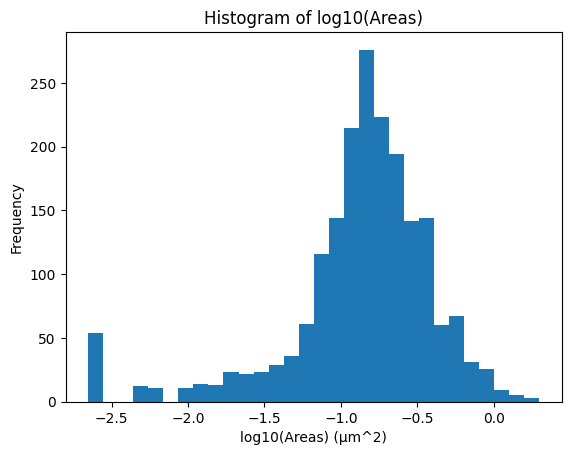

In [ ]:
# prompt: Histogram of log10(all_areas)

import matplotlib.pyplot as plt
import numpy as np

# Assuming 'all_areas' is defined from the previous code
# If not, uncomment the following line and replace with your actual data
# all_areas = np.array([...])

plt.hist(np.log10(all_areas), bins=30)
plt.xlabel('log10(Areas) (μm^2)')
plt.ylabel('Frequency')
plt.title('Histogram of log10(Areas)')
plt.show()

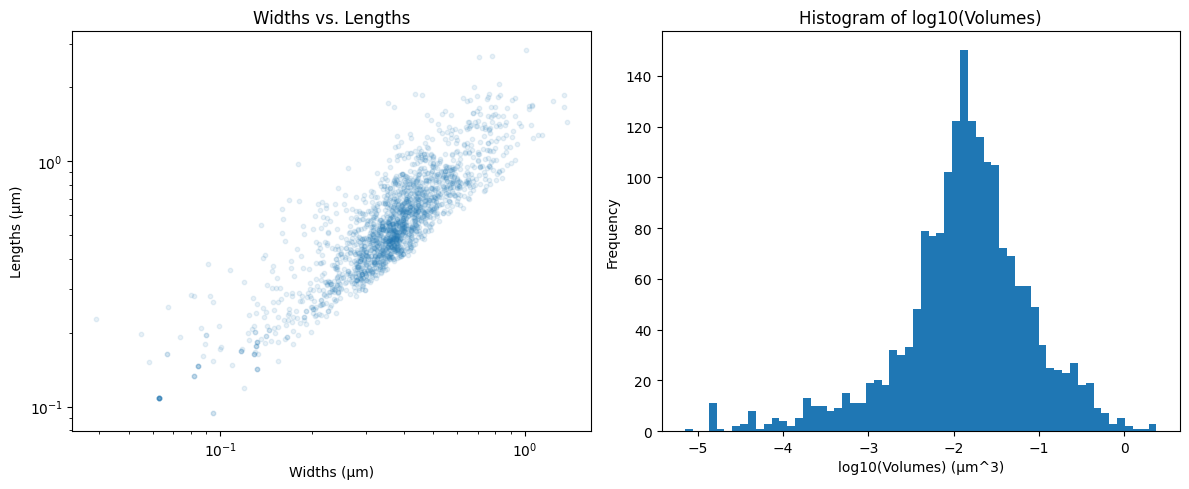

In [ ]:
# prompt: In two subplots, 1. density scatter plot of "all_widths" vs. "all_lengths"; 2. Histogram of log10(all_volumes)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Density scatter plot of widths vs. lengths
axes[0].scatter(all_widths, all_lengths, s=10, alpha=0.1)
axes[0].set_xlabel('Widths (μm)')
axes[0].set_ylabel('Lengths (μm)')
axes[0].set_title('Widths vs. Lengths')
axes[0].set_xscale('log')
axes[0].set_yscale('log')

# Histogram of log10(all_volumes)
axes[1].hist(np.log10(all_volumes), bins=60)
axes[1].set_xlabel('log10(Volumes) (μm^3)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Histogram of log10(Volumes)')

plt.tight_layout()
plt.show()

## 3. Analyze files from all 6 samples

In [ ]:
sample_names = ['sample1', 'sample2', 'sample3','sample4','sample5']
output_dict = {}

for sample_name in sample_names:
  all_areas = analyze_sample(pattern_to_match = sample_name)
  output_dict[sample_name] = all_areas

Files in '/content/drive/MyDrive/Cheng_project3_SAR11_Proteomics/Culture_records/2024_11_06_HTCC1062_Nitrogen_and_Revival/SAR11_Microscopic_Images/' containing 'sample1':
sample1_1.czi
sample1_2.czi
sample1_3.czi
sample1_4.czi
sample1_6.czi
sample1_5.czi
Files in '/content/drive/MyDrive/Cheng_project3_SAR11_Proteomics/Culture_records/2024_11_06_HTCC1062_Nitrogen_and_Revival/SAR11_Microscopic_Images/' containing 'sample2':
sample2-6.czi
sample2-7.czi
sample2-8.czi
sample2-9.czi
sample2-10.czi
sample2-11.czi
sample2-12.czi
sample2-1.czi
sample2-2.czi
sample2-3.czi
sample2-4.czi
sample2-5.czi
Files in '/content/drive/MyDrive/Cheng_project3_SAR11_Proteomics/Culture_records/2024_11_06_HTCC1062_Nitrogen_and_Revival/SAR11_Microscopic_Images/' containing 'sample3':
sample3_2.czi
sample3_6.czi
sample3_7.czi
sample3_8.czi
sample3_9.czi
sample3_10.czi
sample3_11.czi
sample3_12.czi
sample3_13.czi
sample3_14.czi
sample3_15.czi
sample3_16.czi
sample3_1.czi
sample3_3.czi
sample3_5.czi
sample3_4.czi
F

In [ ]:
output_dict['sample5']

array([0.0866814 , 1.46691595, 0.43118439, ..., 0.0022226 , 0.17780799,
       0.0844588 ])

In [ ]:
output_dict['sample1']

array([0.33783519, 0.28449279, 0.144469  , ..., 0.1311334 , 0.144469  ,
       0.0466746 ])

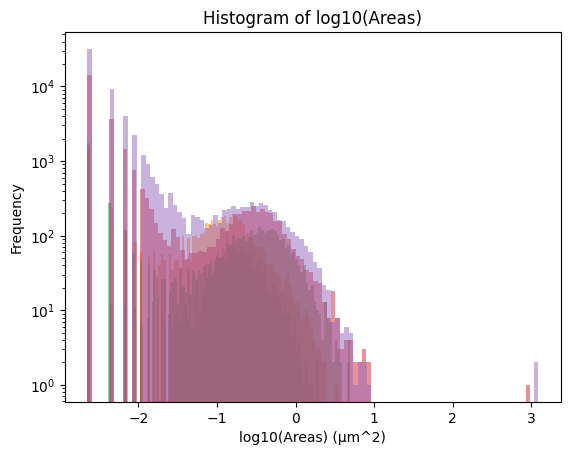

In [ ]:
for sample_name in output_dict:
  plt.hist(np.log10(output_dict[sample_name]), bins=100, label=sample_name, alpha=0.5, log=True)

plt.xlabel('log10(Areas) (μm^2)')
plt.ylabel('Frequency')
plt.title('Histogram of log10(Areas)')
plt.show()